# Chapter 6 - Financial Planning Using Reinforcement Learning

## Listing 6.1

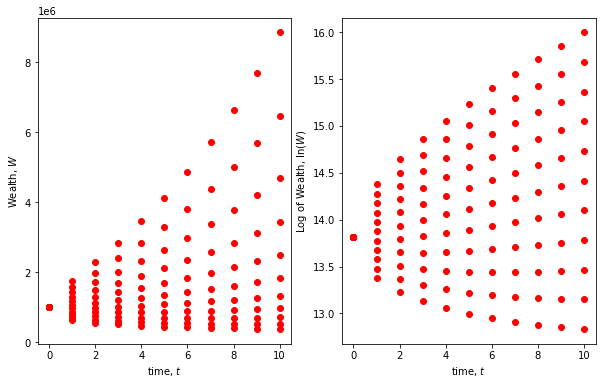

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import log, sqrt, exp

W0 = 1000000
T = 10
nW = 11 #A
mu_stock = 0.08
mu_bond = 0.045
sig_stock = 0.20
sig_bond = 0.0

lnW = np.zeros((nW,T+1))
W = np.zeros((nW, T+1))

for t in range(T+1):
    lnW_min = log(W0) + (mu_stock-0.5*sig_stock**2)*t - 2.5*sig_stock*sqrt(t)
    lnW_max = log(W0) + (mu_stock-0.5*sig_stock**2)*t + 2.5*sig_stock*sqrt(t)
    lnW[:,t] = np.linspace(lnW_min, lnW_max, nW) #B
W = np.exp(lnW)

plt.figure(figsize=(10, 6)) #C
plt.subplot(1,2,1)    
for t in range(T+1):
    plt.scatter(t*np.ones(nW), W[:,t], color='r')
plt.xlabel("time, $t$")
plt.ylabel("Wealth, $W$")
plt.subplot(1, 2, 2)
for t in range(T+1):
    plt.scatter(t*np.ones(nW), lnW[:,t], color='r')
plt.xlabel("time, $t$")
plt.ylabel("Log of Wealth, $\ln(W)$");


#A In the figure below, we used a grid size in wealth of 11, not 101
#B Linear between min and max in log space
#C Plot state space grid


## Listing 6.2

In [7]:
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

def compute_mu_sigma(a):
    mu = a/(nA-1)*mu_stock + (1-a/(nA-1))*mu_bond
    sig = a/(nA-1)*sig_stock
    return mu, sig

def compute_midpoints(W):
    W_midpts = np.zeros((nW+1,T+1))
    W_midpts[0,:] = 0.000001
    W_midpts[nW,:] = np.inf
    W_midpts[1:nW,:] = (W[:nW-1,:]+W[1:nW,:])/2
    return W_midpts

def compute_transition_probs(w, t, a, W_midpts):
    mu, sig = compute_mu_sigma(a)
    W_tplus1_dist = np.zeros(nW)
    cdfs = norm.cdf(np.float64((np.log(W_midpts[:,t+1]/w) - (mu-0.5*sig*sig))
                               /sig)) #A
    W_tplus1_dist = cdfs[1:nW+1] - cdfs[0:nW] #B
    return W_tplus1_dist

#A Standardize return by subtracting mean and dividing by standard deviation, and then get CDF
#B Probability is the difference in adjacent CDF’s

## Figure 6.2

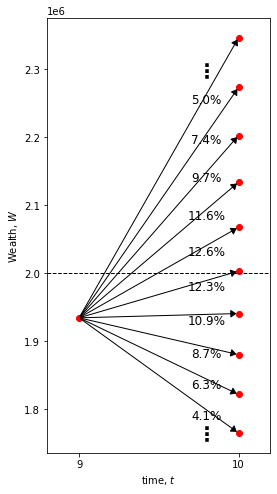

In [8]:
W0 = 1000000
T = 10
nW = 101 #A
mu_stock = 0.08
mu_bond = 0.045
sig_stock = 0.20
sig_bond = 0.0

lnW = np.zeros((nW,T+1))
W = np.zeros((nW, T+1))

for t in range(T+1):
    lnW_min = log(W0) + (mu_stock-0.5*sig_stock**2)*t - 2.5*sig_stock*sqrt(t)
    lnW_max = log(W0) + (mu_stock-0.5*sig_stock**2)*t + 2.5*sig_stock*sqrt(t)
    lnW[:,t] = np.linspace(lnW_min, lnW_max, nW) #B
W = np.exp(lnW)

W9 = 54
W10min = 49
W10max = 59
H = 2000000

V = np.zeros((nW, T+1))
A = np.zeros((nW, T))

for j in range(nW):
    if W[j, T] > H:
        V[j, T] = 1

a = 0.5
mu = a*mu_stock + (1-a)*mu_bond
sig = a*sig_stock
W_next_dist = norm.pdf((np.log(W[:,10]/W[W9,9]) - (mu-0.5*sig*sig))/sig)
W_next_dist = W_next_dist/sum(W_next_dist)
EV = np.dot(W_next_dist, V[:, 10])

plt.figure(figsize=(4, 8)) 
plt.scatter(9, W[W9,9], color='r')
plt.scatter(10*np.ones(W10max-W10min), W[W10min:W10max,10], color='r')
plt.axhline(y=2000000, color='k', linestyle='dashed', lw=1)
#plt.annotate(text='0.5',xy=(9, W[W9,9]), dx=1, dy=W[W10max,10]-W[W9,9], xytext=(9.5,(W[W9,9]+W[W10max,10])/2),arrowprops={})
plt.xticks(np.arange(9, 11, 1))
plt.xlim(8.8, 10.2)
plt.xlabel("time, $t$")
plt.ylabel("Wealth, $W$")
arrowprops = dict(arrowstyle='<|-,head_width=0.4,head_length=0.6', color='k', lw=1)
for i in range(W10max-W10min):
    plt.annotate(text='', xy=(9, W[W9,9]),
             xycoords='data',
             xytext=(10, W[W10min+i,10]),
             ha='center', va='bottom', size=8,
             arrowprops=arrowprops,
            )
    plt.annotate(text=str(round(100*W_next_dist[W10min+i],1))+'%', xy=(9.8, (0.2*W[W9,9]+0.8*W[W10min+i,10])), textcoords='data', xytext=(9.8, (0.2*W[W9,9]+0.8*W[W10min+i,10])),
             ha='center', va='top', size=12,
            )
plt.annotate(text=u"\u22EE", xy=(9.8, 0.96*(W[W9,9]+W[W10min,10])/2), textcoords='data', xytext=(9.8, 0.96*(W[W9,9]+W[W10min,10])/2),
             ha='center', va='top', size=20, weight='bold'
            )
plt.annotate(text=u"\u22EE", xy=(9.8, 1.06*(W[W9,9]+W[W10max,10])/2), textcoords='data', xytext=(9.8, 1.06*(W[W9,9]+W[W10max,10])/2),
             ha='center', va='top', size=20, weight='bold'
            );

## Listing 6.3

In [9]:
G = 2000000
nA = 21
V = np.zeros((nW, T+1)) #A
A = np.zeros((nW, T)) #B
EV = np.zeros(nA) #C
W_midpts = compute_midpoints(W)

for j in range(nW): #D
    if W[j, T] > G: 
        V[j, T] = 1    
        
for t in range(T-1, -1, -1):
    for j in range(nW):
        for a in range(nA):
            W_tplus1_dist = compute_transition_probs(W[j,t], t, a, W_midpts)
            EV[a] = np.dot(W_tplus1_dist, V[:, t+1])
        V[j,t] = EV.max() #E
        A[j,t] = EV.argmax() #F

#A Initialize the two-dimensional optimal value function
#B Initialize the two-dimensional optimal action function
#C Initialize the Expected Value as a function of possible actions
#D Compute the value function in the last time period
#E Save the optimal value for each state
#F Save the optimal action for each state

In [10]:
V[0,0]

0.6802996555240084

## Figure 6.3

In [11]:
Wpath1 = [1000000*1.06**i for i in range(10)]
path1 = [50]
for i in range(1,10):
    path1.append(np.abs(W[:,i]-Wpath1[i]).argmin())
    
Wpath2 = [1000000*1.075**i for i in range(10)]
path2 = [50]
for i in range(1,10):
    path2.append(np.abs(W[:,i]-Wpath2[i]).argmin())
    
Wpath3 = [1000000*1.09**i for i in range(10)]
path3 = [50]
for i in range(1,10):
    path3.append(np.abs(W[:,i]-Wpath3[i]).argmin())

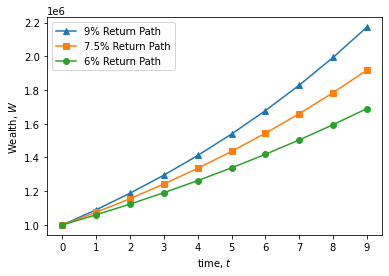

In [12]:
plt.plot(Wpath3, marker='^', label='9% Return Path')
plt.plot(Wpath2, marker='s', label='7.5% Return Path')
plt.plot(Wpath1, marker='o', label='6% Return Path')
plt.legend()
plt.xticks(np.arange(0, 10))
plt.xlabel("time, $t$")
plt.ylabel("Wealth, $W$");

## Figure 6.4

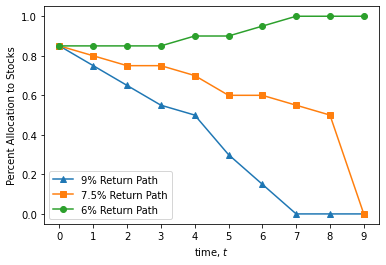

In [13]:
optimalA1 = np.zeros(T)
optimalA2 = np.zeros(T)
optimalA3 = np.zeros(T)
for t in range(T):
    optimalA1[t] = A[path1[t],t]*0.05
    optimalA2[t] = A[path2[t],t]*0.05
    optimalA3[t] = A[path3[t],t]*0.05
plt.plot(optimalA3, marker='^', label='9% Return Path')
plt.plot(optimalA2, marker='s', label='7.5% Return Path')
plt.plot(optimalA1, marker='o', label='6% Return Path')
plt.legend()
plt.xticks(np.arange(0, 10))
plt.xlabel("time, $t$")
plt.ylabel("Percent Allocation to Stocks");

## Listing 6.4

In [14]:
def transition(w, t, a):
    mu, sig = compute_mu_sigma(a)
    W_tplus1 = w * exp(mu-0.5*sig*sig + sig*np.random.normal())
    W_tplus1_idx = (np.abs(W[:,t+1] - W_tplus1)).argmin() #A
    return W_tplus1_idx

#A Find the closest wealth node next period  that corresponds to the next period’s wealth

## Listing 6.5

In [15]:
def Update_Q(w_idx, t, Q):
    if np.random.uniform() < epsilon: #A
        a = np.random.randint(nA)
    else:
        A_array = Q[w_idx, t, :]
        a = np.where(A_array == A_array.max())[0]
        if (len(a)>1): #B
            a = np.random.choice(a)
    W_tplus1_idx = transition(W[w_idx,t], t, a)
    Q[w_idx, t, a] += alpha*(gamma*Q[W_tplus1_idx, t+1, :].max() - Q[W_idx, t, a]) #C
    return W_tplus1_idx, t+1, Q

#A Explore with a probability epsilon
#B If more than one action has the same Q, choose one of them randomly
#C This implements the Q-Learning update equation that was discussed in the text

## Listing 6.6

In [16]:
from tqdm import tqdm

n_episodes = 1000000
epsilon = 0.5
alpha = 0.1
gamma = 1.0

Q = np.zeros((nW, T+1, nA))
for j in range(nW):
    if W[j, T]>G:
        Q[j, T, :] = 1

for i in tqdm(range(n_episodes), desc="Running..."):
    W_idx = 0
    t = 0
    while t<=(T-1):
        W_idx, t, Q = Update_Q(W_idx, t, Q)

Running...: 100%|██████████████████████████████████████████████████████████| 1000000/1000000 [06:20<00:00, 2626.92it/s]


## Listing 6.7

In [17]:
W0 = 1000000
T = 10
nW = 101
mu_stock = 0.08
mu_bond = 0.045
sig_stock = 0.20
sig_bond = 0.0

Cbar = np.zeros(T+1)
Cbar[0] = 0
for t in range(1, T+1):
    Cbar[t] = Cbar[t-1] + 1/(T-t+1)

lnW = np.zeros((nW,T+1))
W = np.zeros((nW, T+1))

for t in range(T+1):
    lnW_min = log(W0) - t*log(3) #A
    lnW_max = log(W0) - Cbar[t] + (mu_stock-0.5*sig_stock**2)*t + 2.5*sig_stock*sqrt(t)
    lnW[:,t] = np.linspace(lnW_min, lnW_max, nW)
W = np.exp(lnW)

#A The potential minimum wealth is lower because of consumption 

## Listing 6.8

In [18]:
nA = 11
nC = 40
V = np.zeros((nW, T+1))
A = np.zeros((nW, T))
C = np.zeros((nW, T)) #A
EV = np.zeros((nA, nC))
W_midpts = compute_midpoints(W)

gamma = 0.95 #B
CRRA = 3 #C
def utility(c): #D
    if (CRRA == 1):
        util = log(c)
    else:
        util = (c**(1-CRRA))/(1-CRRA)
    return util

for j in range(nW):
        V[j, T] = utility(W[j,T]) #E 
        
for t in range(T-1, -1, -1):
    for j in range(nW):
        for a in range(nA):
            for c in range(nC):
                cons = (c+1)/(1.5*nC)*W[j,t] #F
                W_tplus1_dist = compute_transition_probs(W[j,t]-cons, t, a, W_midpts) #G
                EV[a,c] = np.dot(W_tplus1_dist, utility(cons)+gamma*V[:,t+1]) #H
        V[j,t] = EV.max()
        A[j,t], C[j,t] = np.unravel_index(EV.argmax(), EV.shape) #I

#A Initialize the two-dimensional optimal consumption
#B The subjective discount rate
#C The coefficient of constant relative risk aversion
#D Power utility function
#E In the last period, all wealth is consumed
#F Consumption is a percentage of wealth
#G Consumption is subtracted from wealth before computing the transition probabilities
#H Current value is utility from consumption plus discounted expected value next period
#I Returns the row (asset allocation) and column (consumption) for optimal solution

## Listing 6.9

In [20]:
def Update_Q(w_idx, t, Q):
    if np.random.uniform() < epsilon:
        a = np.random.randint(nA)
        c = np.random.randint(nC)
    else:
        AC_array = Q[w_idx,t,:,:]
        ac = np.argwhere(AC_array == AC_array.max()) #A
        if (len(ac)>1):
            a,c = ac[np.random.choice(len(ac))]
        else:
            a,c = ac[0]
    cons = (c+1)/(1.5*nC)*W[w_idx,t]
    W_tplus1_idx = transition(W[w_idx,t]-cons, t, a) #B
    Q[w_idx,t,a,c] += alpha*(utility(cons) + gamma*Q[W_tplus1_idx,t+1,:,:].max() -
                                                   Q[W_idx,t,a,c]) #C
    return W_tplus1_idx, t+1, Q

#A Row (asset allocation) and column (consumption) of highest Q
#B Consumption is subtracted from wealth before computing random next state
#C This implements the Q-Learning update equation that was discussed in the text, including current consumption

## Listing 6.10

In [21]:
from tqdm import tqdm

n_episodes = 5000000
epsilon = 0.5
alpha = 0.1
gamma = 0.95

Q = np.zeros((nW, T+1, nA, nC))
for j in range(nW):
        Q[j,T,:,:] = utility(W[j,T]) #A

for i in tqdm(range(n_episodes), desc="Running..."):
    W_idx = 0
    t = 0
    while t<=(T-1):
        W_idx, t, Q = Update_Q(W_idx, t, Q)

#A Initialize Q in the final time period to the utility of final wealth

Running...: 100%|██████████████████████████████████████████████████████████| 5000000/5000000 [36:30<00:00, 2282.26it/s]


## Longevity Risk